In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection
sns.set(rc={'figure.figsize':(10,10)})

In [19]:
boston_data = datasets.load_boston()
df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df_boston['target'] = pd.Series(boston_data.target)
train, test = model_selection.train_test_split(df_boston, test_size=0.2)
train_X = train.drop('target', axis=1).values
train_y = train['target'].values
test_X = test.drop('target', axis=1).values
test_y = test['target'].values
train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
289,0.04297,52.5,5.32,0.0,0.405,6.565,22.9,7.3172,6.0,293.0,16.6,371.72,9.51,24.8
176,0.07022,0.0,4.05,0.0,0.510,6.020,47.2,3.5549,5.0,296.0,16.6,393.23,10.11,23.2
477,15.02340,0.0,18.10,0.0,0.614,5.304,97.3,2.1007,24.0,666.0,20.2,349.48,24.91,12.0
391,5.29305,0.0,18.10,0.0,0.700,6.051,82.5,2.1678,24.0,666.0,20.2,378.38,18.76,23.2
384,20.08490,0.0,18.10,0.0,0.700,4.368,91.2,1.4395,24.0,666.0,20.2,285.83,30.63,8.8


### Algorithm - Regression Tree

Regression trees were cooked up in the famous CART paper penned by Leo Breiman, Jerome Friedman and Charles J. Stone in 1984.

In [21]:
def compute_sum_split_variance(xs, y, v):
    '''xs - 1D array of scalars
        v - scalar to split on'''
    left = y[xs <= v]
    right = y[xs > v]
    left_var = 0 if len(left) == 0 else ((left - left.mean()) ** 2).sum()
    right_var = 0 if len(right) == 0 else ((right - right.mean()) ** 2).sum()
    return  left_var + right_var

def node(i, s, p, c, l, r):
    return {'internal': i,
            'split': s,
            'p': p,
            'c':c,
            'l':l,
            'r':r}

def gen_reg_tree(X, y, max_leaf_n):
    if X.shape[0] <= max_leaf_n:
        return node(False, None, None, y.mean(), None, None) 
    lowest_var, best_p_idx, best_split = sys.float_info.max, None, None
    for p_idx in range(0, X.shape[1]):
        for n_idx in range(0, X.shape[0]):
            split = X[n_idx][p_idx]
            var = compute_sum_split_variance(X[:,p_idx], y, split)
            if var < lowest_var:
                lowest_var = var
                best_p_idx = p_idx
                best_split = split
    left_idxs = X[:, best_p_idx] <= best_split
    right_idxs = X[:, best_p_idx] > best_split    
    if len(y[left_idxs]) == 0 or len(y[right_idxs]) == 0:
        # this happens if yi = yi+1 ... = yn
        # in which case.. there is no benefit to branching more.
        assert(np.unique(y).size == 1)
        return node(False, None, None, y.mean(), None, None)
    l = gen_reg_tree(X[left_idxs], y[left_idxs], max_leaf_n)
    r = gen_reg_tree(X[right_idxs], y[right_idxs], max_leaf_n)
    return node(True, best_split, best_p_idx, None, l, r)

def predict(x, model):
    if not model['internal']:
        return model['c']
    return predict(x, model['l']) if x[model['p']] <= model['split'] else predict(x, model['r'])

**Example 1**: Visualisation with a generated dataset

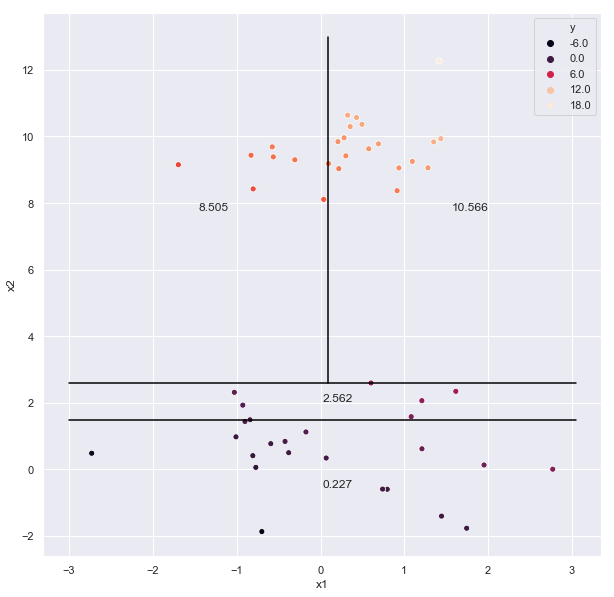

In [48]:
def plot_boundries(tree, xmin, xmax, ymin, ymax):
    if not tree['internal']:
        x = xmin + (0.5 * (xmax - xmin))
        y = ymin + (0.5 * (ymax - ymin))
        plt.text(x, y, round(tree['c'], 3))
        return
    s = tree['split']
    if tree['p'] == 0:
        plt.plot([s, s], [ymin, ymax], c='black')
        plot_boundries(tree['l'], xmin, s, ymin, ymax)
        plot_boundries(tree['r'], s, xmax, ymin, ymax)
    else:
        plt.plot([xmin, xmax],[s, s], c='black')
        plot_boundries(tree['l'], xmin, xmax, ymin, s)
        plot_boundries(tree['r'], xmin, xmax, s, ymax)
        
def fit_n_plot_boundries(X, y, max_leaf_n):
    scatter_df = pd.concat([pd.DataFrame(X, columns=['x1', 'x2']), pd.Series(y, name='y')], axis=1)
    ax = sns.scatterplot(x='x1', y='x2', hue='y' ,data=scatter_df, palette='rocket')
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    tree = gen_reg_tree(X, y, max_leaf_n)
    plot_boundries(tree, xmin, xmax, ymin, ymax)
    
n = 100
k = 4
class_1 = np.random.normal([0, 1], 1, (n//k, 2))
class_2 = np.random.normal([0, 10], 1,(n//k, 2))
df = pd.concat([pd.DataFrame(class_1), pd.DataFrame(class_2)], axis=0, ignore_index=True)
X = df.values
y = X.sum(axis=1)
max_leaf_n = 20
fit_n_plot_boundries(X,y, max_leaf_n)

**Example 2**: Performance on Boston 

In [25]:
max_leaf_n = 2
tree = gen_reg_tree(train_X, train_y, max_leaf_n)

# evaluate training error
preds = [predict(r, tree) for r in train_X]
print('training error: {}'.format(np.sqrt(((train_y - preds) ** 2).sum() / train_y.shape[0])))

# evaluate test error
preds = [predict(r, tree) for r in test_X]
print('test error: {}'.format(np.sqrt(((test_y - preds) ** 2).sum() / test_y.shape[0])))

training error: 0.32033012056098287
test error: 6.976984221246986


### Algorithm - Bagged Regression Trees

Leo Brieman [first described bagging in 1996](https://link.springer.com/content/pdf/10.1023%2FA%3A1018054314350.pdf).

In [28]:
def bagged_predict(x, trees):
    return np.array([predict(x, t) for t in trees]).mean()
    
def bagged_trees(X, y, max_leaf_n, b):
    n = X.shape[0]
    trees = []
    for _ in range(0,b):
        b_sample = np.random.randint(0, n, n)
        trees.append(gen_reg_tree(X[b_sample], y[b_sample], max_leaf_n))
    return trees

**Example**: Performance on Boston

In [46]:
max_leaf_n = 2
b = 50
trees = bagged_trees(train_X, train_y, max_leaf_n, b)

# evaluate test error
preds = [bagged_predict(x, trees) for x in test_X]
print('test error: {}'.format(np.sqrt(((test_y - preds) ** 2).sum() / test_y.shape[0])))

test error: 4.766596508464903


### Algorithm - Random Forests Regression

Tin Kam Ho is credited with [the first description](https://web.archive.org/web/20160417030218/http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf) of random decision forests in 1995. Leo Brieman is credited with [the introduction of random forests proper]((https://link.springer.com/article/10.1023%2FA%3A1010933404324)) in 2001.

In [36]:
def gen_random_forest_tree(X, y, max_leaf_n, m):
    if X.shape[0] <= max_leaf_n:
        return node(False, None, None, y.mean(), None, None)
    lowest_var, best_p_idx, best_split = sys.float_info.max, None, None
    # Putting the 'random' in random forests..
    ps = np.random.choice(np.arange(0,X.shape[1]), m, replace=False)
    for p_idx in ps:
        for n_idx in range(0, X.shape[0]):
            split = X[n_idx][p_idx]
            var = compute_sum_split_variance(X[:,p_idx], y, split)
            if var < lowest_var:
                lowest_var = var
                best_p_idx = p_idx
                best_split = split
    left_idxs = X[:, best_p_idx] <= best_split
    right_idxs = X[:, best_p_idx] > best_split
    if len(y[left_idxs]) == 0 or len(y[right_idxs]) == 0:
        # This happens when: yi = yi+1 ... = yn OR xi = xi+1 .... = xn
        return node(False, None, None, y.mean(), None, None)
    l = gen_random_forest_tree(X[left_idxs], y[left_idxs], max_leaf_n, m)
    r = gen_random_forest_tree(X[right_idxs], y[right_idxs], max_leaf_n, m)
    return node(True, best_split, best_p_idx, None, l, r)

def random_forest_trees(X, y, max_leaf_n, b, m):
    n = X.shape[0]
    trees = []
    for _ in range(0,b):
        b_sample = np.random.randint(0, n, n)
        trees.append(gen_random_forest_tree(X[b_sample], y[b_sample], max_leaf_n, m))
    return trees

**Example**: Performance on Boston

In [43]:
max_leaf_n = 2
b = 100
m = int(np.floor(np.sqrt(train_X.shape[1])))
trees = random_forest_trees(train_X, train_y, max_leaf_n, b, m)

# evaluate test error
preds = [bagged_predict(x, trees) for x in test_X]
print('test error: {}'.format(np.sqrt(((test_y - preds) ** 2).sum() / test_y.shape[0])))

test error: 4.611756849044611
